# EDA Bivariate

In [3]:
import pandas as pd
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
data = pd.read_csv('amz_uk_price_prediction_dataset.csv')
df = data.copy()
df.head(5)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


## Part 1: Analyzing Best-Seller Trends Across Product Categories
Understand the relationship between product categories and their best-seller status.

### Crosstab Analysis
Are there categories where being a best-seller is more prevalent? 

In [5]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'])
crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [6]:
crosstab2 = pd.crosstab(df['category'], df['isBestSeller'], normalize='index')
crosstab2.columns = ['Not Best Seller', 'Best Seller']
sorted_crosstab2 = crosstab2.sort_values(by='Best Seller', ascending=False)
sorted_crosstab2

,Not Best Seller,Best Seller
category,,
Grocery,0.941865,0.058135
Smart Home Security & Lighting,0.942308,0.057692
Health & Personal Care,0.942314,0.057686
Mobile Phone Accessories,0.957529,0.042471
Power & Hand Tools,0.964661,0.035339
...,...,...
Bedding Collections,1.000000,0.000000
CPUs,1.000000,0.000000
"CD, Disc & Tape Players",1.000000,0.000000


In [7]:
crosstab = pd.crosstab(df['category'], df['isBestSeller'], normalize='index')
# Count of products per category
count_table = pd.crosstab(df['category'], df['isBestSeller'])

# Merge proportions and counts
combined = crosstab.join(count_table, rsuffix='_count')

combined.head()


isBestSeller,False,True,False_count,True_count
category,,,,
3D Printers,0.995968,0.004032,247,1
3D Printing & Scanning,0.999508,0.000492,4065,2
Abrasive & Finishing Products,0.980000,0.020000,245,5
Action Cameras,0.999411,0.000589,1696,1
Adapters,0.988189,0.011811,251,3


* Yes, there are categories where being a best-seller is more prevalent.

### Statistical Tests
Chi-square test to determine if the best-seller distribution is independent of the product category.
Cramér's V to understand the strength of association between best-seller status and category.


In [8]:
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared: {chi2}")
print(f"P-value: {p}")

Chi-squared: 36540.20270061387
P-value: 0.0


In [9]:
n = contingency_table.sum().sum()
phi2 = chi2 / n
r, k = contingency_table.shape
cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.1222829439760564


### Visualizations
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

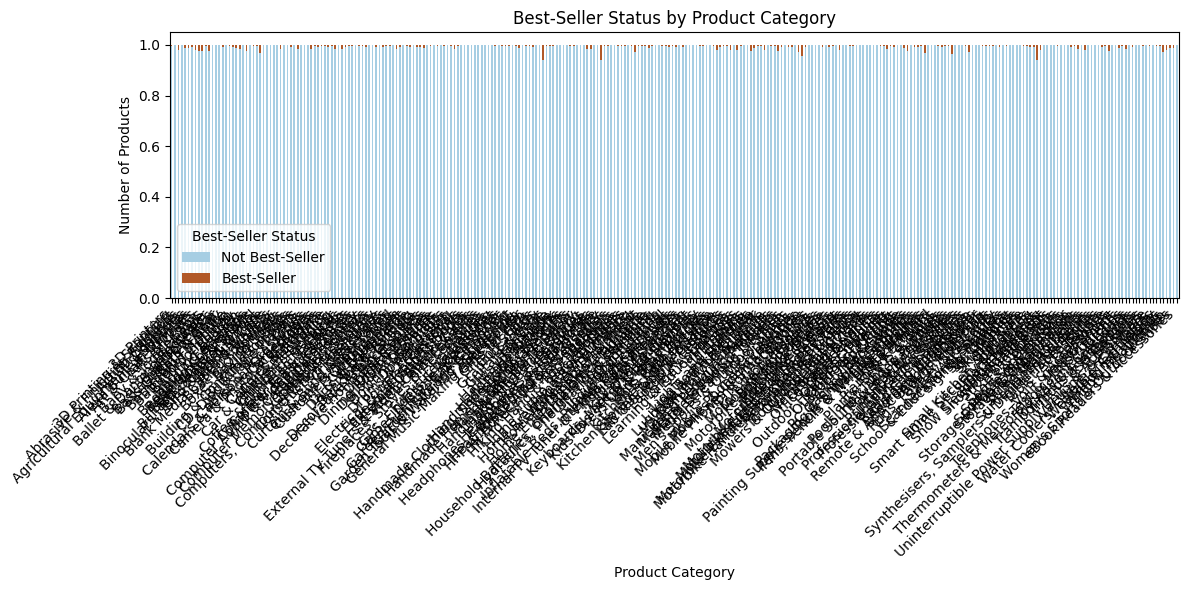

In [10]:
crosstab2.columns = ['Not Best-Seller', 'Best-Seller']

# Plot
crosstab2.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Paired')

plt.title('Best-Seller Status by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Best-Seller Status')
plt.tight_layout()
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Investigate how different product categories influence product prices.

### Preliminary Step: Remove outliers in product prices.

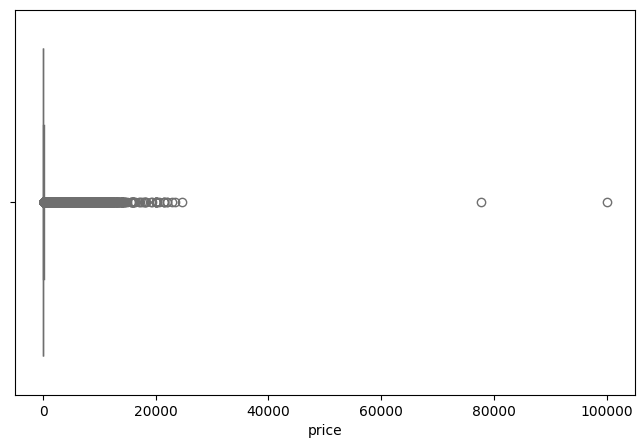

In [11]:
# visualize outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=df['price'], color="skyblue")
plt.show()

In [12]:
# Step 1: Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define lower and upper bounds for non-outlier prices
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter the DataFrame to remove outliers
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

print(f"Original dataset size: {df.shape[0]}")
print(f"After removing outliers: {df_no_outliers.shape[0]}")
print(f"Removed {df.shape[0] - df_no_outliers.shape[0]} outliers.")



Original dataset size: 2443651
After removing outliers: 2115963
Removed 327688 outliers.


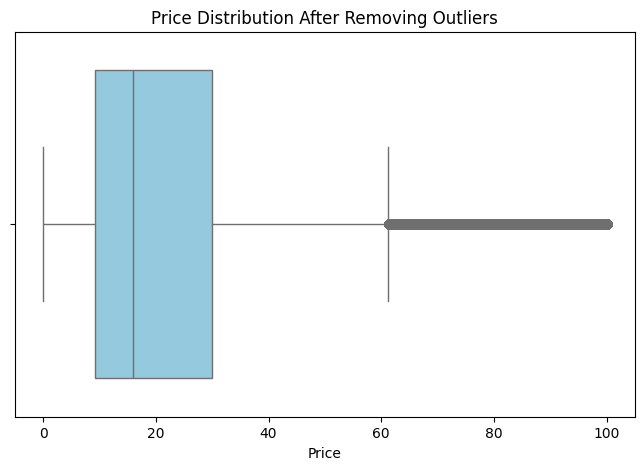

In [13]:
# Visualize the distribution of prices after removing outliers
plt.figure(figsize=(8,5))
sns.boxplot(x=df_no_outliers['price'], color="skyblue")
plt.title('Price Distribution After Removing Outliers')
plt.xlabel('Price')
plt.show()  

### Violin Plots
Visualize the distribution of `price` across different product `categories` filtering out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price?

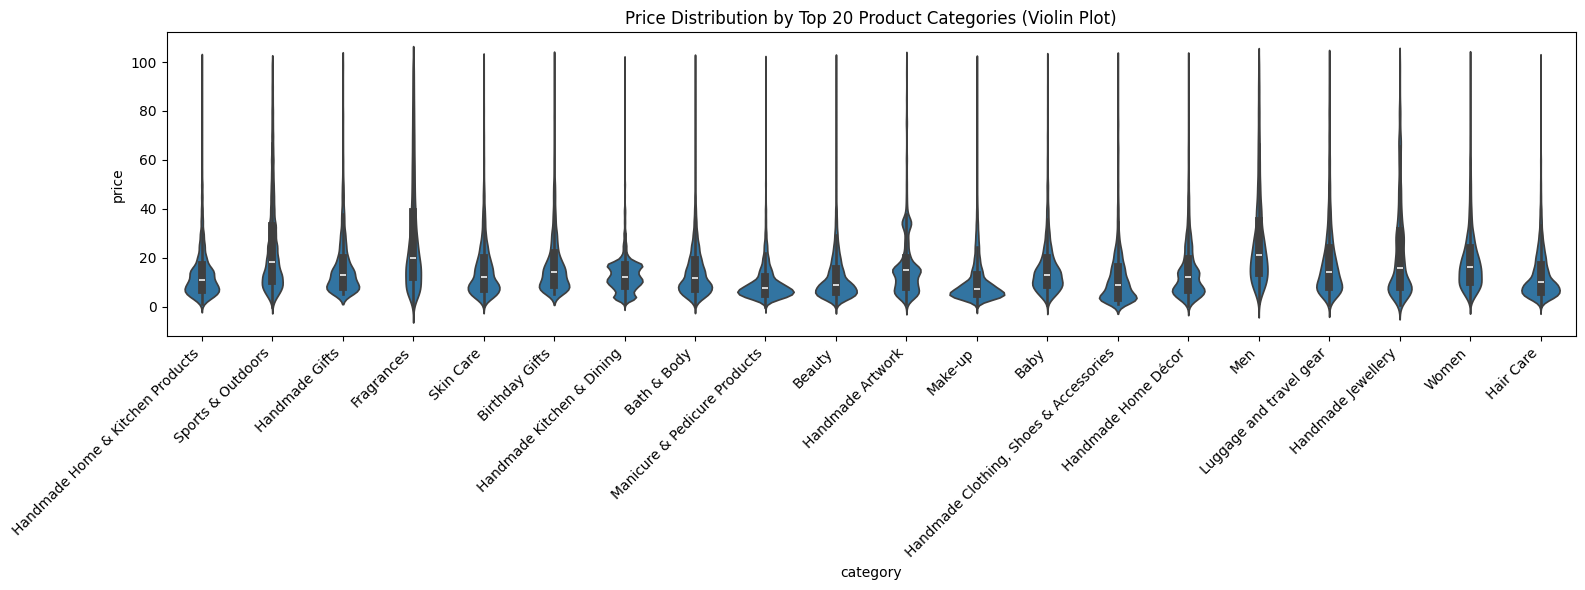

In [14]:
# Top 20 categories by product count
top20_categories = df_no_outliers['category'].value_counts().head(20).index
filtered_df = df_no_outliers[df_no_outliers['category'].isin(top20_categories)]

plt.figure(figsize=(16, 6))
sns.violinplot(data=filtered_df, x='category', y='price', inner='box')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution by Top 20 Product Categories (Violin Plot)')
plt.tight_layout()
plt.show()

### Bar Charts
Comparing the average price of products for the top 10 product categories (based on count)
- Which product category commands the highest average price? Don't filter here by top categories.

C:\Users\PC\AppData\Local\Temp\ipykernel_14976\277200737.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=filtered_df_top10, x='category', y='price', estimator='mean', ci=None)


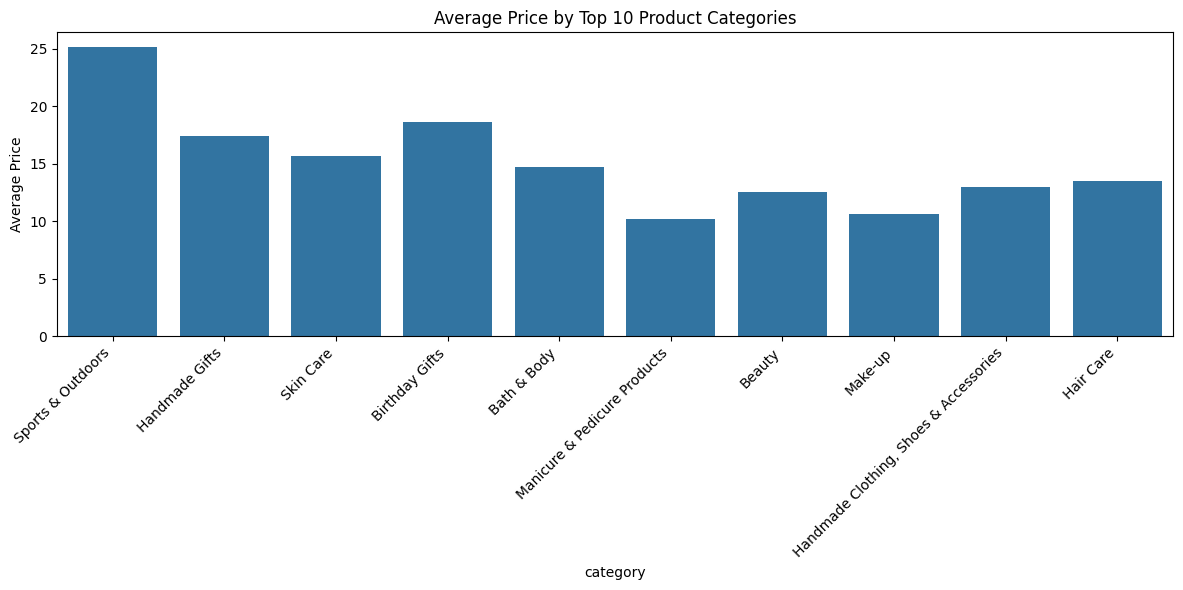

In [15]:
# Top 10 categories by count
top10_categories = df_no_outliers['category'].value_counts().head(10).index
filtered_df_top10 = df_no_outliers[df_no_outliers['category'].isin(top10_categories)]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df_top10, x='category', y='price', estimator='mean', ci=None)
plt.xticks(rotation=45, ha='right')
plt.title('Average Price by Top 10 Product Categories')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

### Box Plots
Distribution of product `ratings` based on their `category` using side-by-side box plots filtering out the top 10 categories based on count for better visualization.
- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

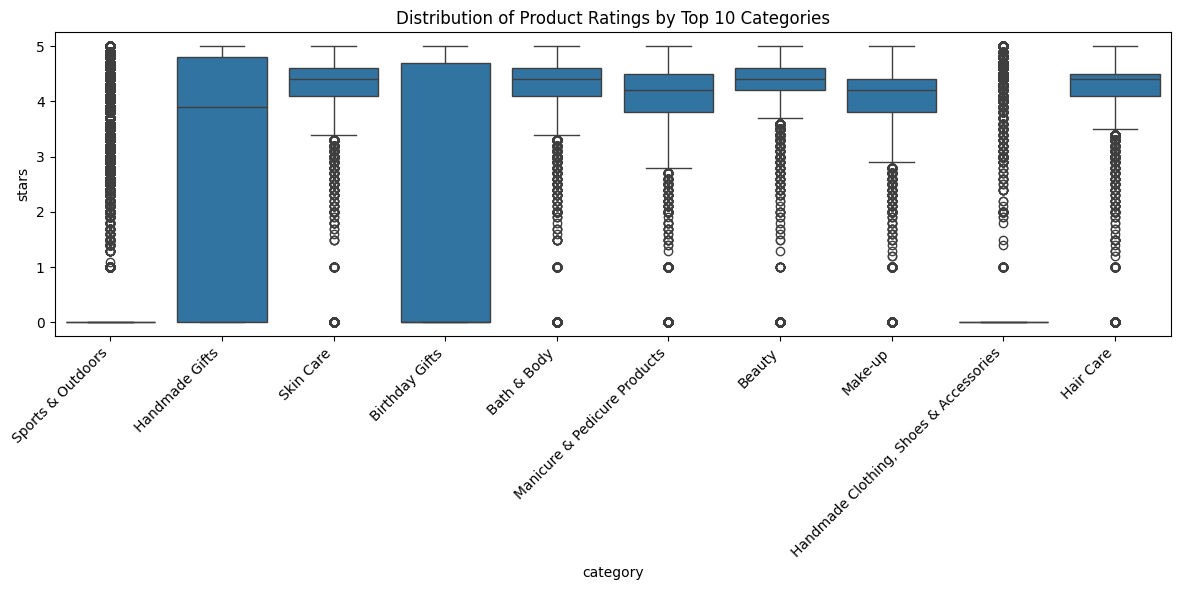

In [16]:
# Top 10 by count
top10_categories_ratings = df_no_outliers['category'].value_counts().head(10).index
filtered_ratings = df_no_outliers[df_no_outliers['category'].isin(top10_categories_ratings)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_ratings, x='category', y='stars')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Product Ratings by Top 10 Categories')
plt.tight_layout()
plt.show()

## Part 3: Investigating the Interplay Between Product Prices and 
Analyze how product ratings (`stars`) correlate with product prices.

### Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [17]:
correlation = df_no_outliers['price'].corr(df_no_outliers['stars'])

print(f"Correlation coefficient between price and stars: {correlation:}")

Correlation coefficient between price and stars: -0.07767299878181444


### Visualizations
Scatter plot visualizing the relationship between product rating and price.

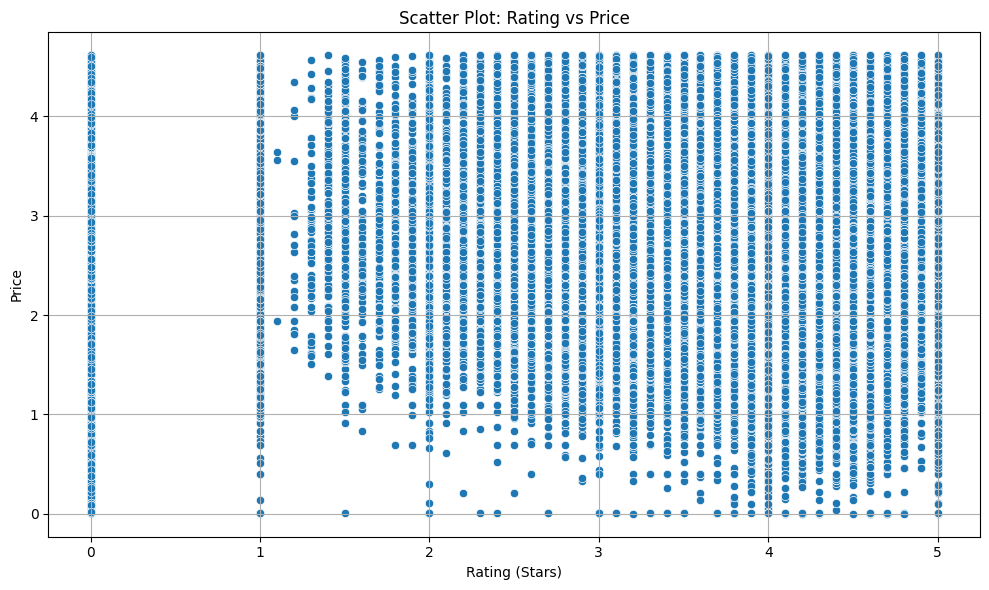

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='stars', y=np.log1p(df_no_outliers['price']))
plt.title('Scatter Plot: Rating vs Price')
plt.xlabel('Rating (Stars)')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

* Correlation heatmap visualizing correlations between all numerical variables.

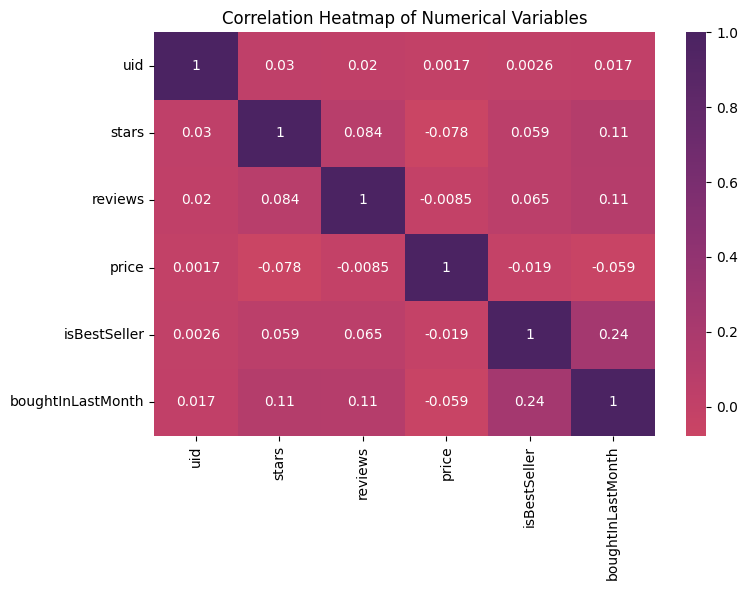

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_no_outliers.corr(numeric_only=True), annot=True, cmap='flare', center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

* QQ plot examining if product prices typically follow a normal distribution. 

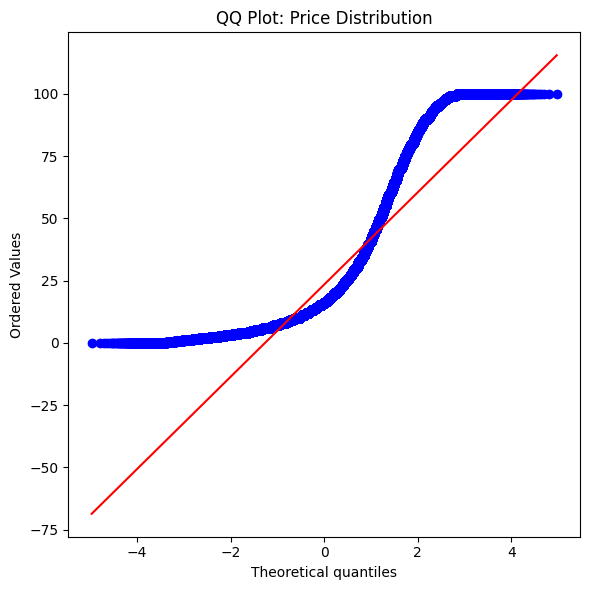

In [20]:
plt.figure(figsize=(6, 6))
st.probplot(df_no_outliers['price'], dist="norm", plot=plt)
plt.title('QQ Plot: Price Distribution')
plt.tight_layout()
plt.show()